------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------



Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002).
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.


**Implementation**

While we inserted code cells to indicate where you should implement your own code, please feel free to add/remove code blocks where you see fit (but make sure that the general structure of the assignment is preserved). Also, please keep in mind that it is always good practice to structure your code properly, e.g., by implementing separate classes and functions that can be reused.

## Environment

All code should be written in **Python 3**.
This is the default in Google Colab.

In [ ]:
!python --version

Python 3.10.12


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download).
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.


**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [ ]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [ ]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2023-11-15 16:07:44--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon’

sent_lexicon        100%[===================>] 647.05K  --.-KB/s    in 0.03s   

2023-11-15 16:07:45 (23.5 MB/s) - ‘sent_lexicon’ saved [662577/662577]

--2023-11-15 16:07:45--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [ ]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list}
#  {"cv": integer, "sentiment": str, "content": list}
#   ..
# ]
# where `content` is a list of sentences,
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4:
    break

c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1

print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))


Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [ ]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [ ]:
# YOUR CODE HERE

# loading sentiment lexicon of each word
def load_sentiment_lexicon():
  lexicon = {}
  with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    for line in f:
      entries = line.strip().split()
      word = entries[2].split('=')[1]
      ppolarity = entries[5].split('=')[1]

      if ppolarity == 'positive':
        lexicon[word] = 1
      elif ppolarity == 'negative':
        lexicon[word] = -1

    return lexicon


# calculating binary_score of review
def calculate_sentiment_score(review, lex, threshold):
  bscore_rev = 0
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      word = token.lower()
      bscore_rev += lex.get(word, 0) # return 0 instead of None if word is not in lexicon

  return 1 if bscore_rev > threshold else 0

sent_lexicon = load_sentiment_lexicon()

In [ ]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...]
# where 1 indicates a correct classification and 0 an incorrect classification
token_results = []
binary_threshold = 8
for review in reviews:
  predicted_senti = calculate_sentiment_score(review, sent_lexicon, binary_threshold)
  actual_senti = 1 if review['sentiment'] == 'POS' else 0

  # compare predicted and true value
  if predicted_senti == actual_senti:
    token_results.append(1)
  else:
    token_results.append(0)

token_accuracy = sum(token_results) / len(token_results)
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [ ]:
# YOUR CODE HERE

# same as before but updated with magnitude
def load_sentiment_lexicon(use_magnitude=False):
  lexicon = {}
  with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    for line in f:
      entries = line.strip().split()
      word = entries[2].split('=')[1]
      ppolarity = entries[5].split('=')[1]
      if use_magnitude:
        type_strength = entries[0].split('=')[1]  # get magnitude
        # determining weight based on the magnitude
        if type_strength == 'strongsubj':
          weight = 5
        elif type_strength == 'weaksubj':
          weight = 1
      else:
          weight = 1

      if ppolarity == 'positive':
        lexicon[word] = weight
      elif ppolarity == 'negative':
        lexicon[word] = -1 * weight

    return lexicon

sent_lexicon = load_sentiment_lexicon(use_magnitude=True)

In [ ]:
magnitude_results = [] # a list of binary indicators
magnitude_threshold = 18
for review in reviews:
  predicted_senti = calculate_sentiment_score(review, sent_lexicon, magnitude_threshold)
  actual_senti = 1 if review['sentiment'] == 'POS' else 0

  # comparing predicted and true value
  if predicted_senti == actual_senti:
    magnitude_results.append(1)
  else:
    magnitude_results.append(0)

magnitude_accuracy = sum(magnitude_results) / len(magnitude_results)
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.70


#### (Q.1.3) Make a barplot of the two results (0.5pt)

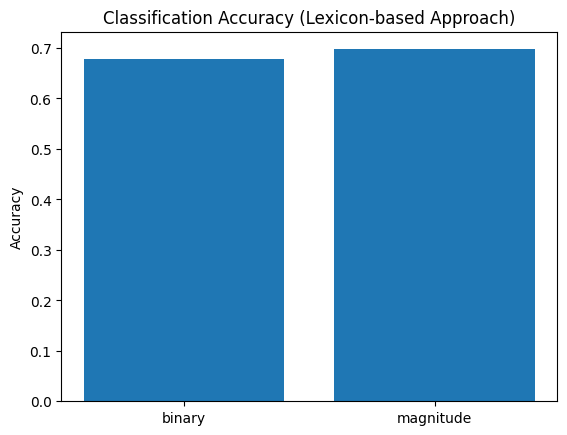

In [ ]:
# YOUR CODE HERE

plt.bar(["binary", "magnitude"], [token_accuracy, magnitude_accuracy])
plt.title("Classification Accuracy (Lexicon-based Approach)")
plt.ylabel("Accuracy")
plt.show()

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

Using a fixed threshold doesn't take into account the document length. This can be problematic because a very long review would have more opportunities to include positive words not necessarily because it's expressing a stronger positive sentiment but because of its length. So if this long review is just long enough to pass the threshold, it would be classified as positive even if it might not be. This can result in longer reviews being classified as positive just because of their length, and not because of their sentiment. For example, a long review with 8 positive words out of 100 could be predicted as positive, even if the remaining words are negative (or neutral). Hence, instead of fixed threshold we could normalize the sentiment score by the length of the document. In other words, we can calculate the average sentiment per word. This will make the threshold adaptive to the length of the document.

In [ ]:
# YOUR CODE HERE

# calculating normalized binary_score of review
def calculate_sentiment_score(review, lex, threshold):
  bscore_rev = 0
  total_tokens = 0
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      word = token.lower()
      bscore_rev += lex.get(word, 0)
      total_tokens += 1

  # calculating average score per word
  norm_score = bscore_rev / total_tokens
  return 1 if norm_score > threshold else 0


results = [] # a list of binary indicators
threshold = 0.04
for review in reviews:
  predicted_senti = calculate_sentiment_score(review, sent_lexicon, threshold)
  actual_senti = 1 if review['sentiment'] == 'POS' else 0
  # comparing predicted and true value
  if predicted_senti == actual_senti:
    results.append(1)
  else:
    results.append(0)

accuracy = sum(results) / len(results)
print("Accuracy: %0.2f" % accuracy)

Accuracy: 0.70


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes at test time**.  What would be the problem instead with skipping words only for one class in case 2?

If a word only appears in one class during training and we don't skip it during testing, then this would lead to bias. NB classifier multiplies the individual probabilities of each word in a document and so, a probability of $0$ for any word would cause the probability of the document belonging to the class that did not include the word to become zero. Hence, the bias would be towards the class that contained the word during training since it won't get affected in the multiplication of probabilities. This could result in misclassification.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [ ]:
# YOUR CODE HERE

# computing prior P(c)
def calc_prior_probs(doc_class_counts, total_docs):
  priors = {}
  for c in doc_class_counts:
    priors[c] = math.log(doc_class_counts[c] / total_docs)

  return priors

# calculating conditional probs P(word|c)
def calc_cond_probs(freqs, word_total, vocab):
  cond_probs_POS = {}
  cond_probs_NEG = {}

  for word in vocab:
    # overcoming issue of unseen words by
    # skipping words that have frequency of 0 in either one of the classes
    if freqs['POS'][word] == 0 or freqs['NEG'][word] == 0:
      continue

    if freqs['POS'][word] > 0:
      word_freq_POS = freqs['POS'][word]
      cond_probs_POS[word] = math.log(word_freq_POS / word_total['POS'])

    if freqs['NEG'][word] > 0:
      word_freq_NEG = freqs['NEG'][word]
      cond_probs_NEG[word] = math.log(word_freq_NEG / word_total['NEG'])

  return cond_probs_POS, cond_probs_NEG

# predicting
def classify_reviews(review, cond_probs, prior_probs):
  results = {'POS': prior_probs['POS'], 'NEG': prior_probs['NEG']}

  # for each word in a new review, adding the sum of the log probabs
  for sentence in review['content']:
    for token, post_tag in sentence:
      word = token.lower()
      # only ad  the log probs of word in it exists in both of the classes
      if word in cond_probs['POS'] and word in cond_probs['NEG']:
        results['POS'] += cond_probs['POS'].get(word, 0)
        results['NEG'] += cond_probs['NEG'].get(word, 0)

  # finding argmax of class
  if results['POS'] > results['NEG']:
    return 'POS'
  else:
    return 'NEG'

# splitting data
def split_data(reviews):
  train_set = []
  test_set = []
  for review in reviews:
    if review['cv'] < 900:
      train_set.append(review)
    else:
      test_set.append(review)

  return train_set, test_set

def train(train_set):
  # preprocessing and counting
  vocab = set()
  doc_class_count = {'POS': 0, 'NEG': 0}
  word_class_count = {'POS': 0, 'NEG': 0}
  word_freqs_class = {'POS': Counter(), 'NEG': Counter()}

  for review in train_set:
    doc_class_count[review['sentiment']] += 1
    for sentence in review['content']:
      for token, post_tag in sentence:
        word = token.lower()
        vocab.add(word)
        word_freqs_class[review['sentiment']][word] += 1
        word_class_count[review['sentiment']] += 1

  # calculating the prior probabilities
  total_doc_count = sum(doc_class_count.values())
  log_prior_probs = calc_prior_probs(doc_class_count, total_doc_count)

  # calculating the conditional probabilities
  log_cond_probs_POS, log_cond_probs_NEG = calc_cond_probs(word_freqs_class, word_class_count, vocab)
  log_cond_probs = {'POS': log_cond_probs_POS, 'NEG': log_cond_probs_NEG}

  return vocab, log_prior_probs, log_cond_probs

def test(test_set, vocab, log_prior_probs, log_cond_probs):
  preds_correct_count = 0

  for review in test_set:
    predicted_class = classify_reviews(review, log_cond_probs, log_prior_probs)
    true_class = review['sentiment']
    if predicted_class == true_class:
      preds_correct_count += 1

  # computing accuracy
  accuracy = preds_correct_count / len(test_set)
  return accuracy


train_set, test_set = split_data(reviews)
vocab, log_prior_probs, log_cond_probs = train(train_set)
accuracy = test(test_set, vocab, log_prior_probs, log_cond_probs)
print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.82


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

If 90% of the data instances are positive movie reviews, then we obtain significant class imbalance. In such case, the classifier might be biased towards the majority class (positive reviews), and so, accuracy would not be a fair performance measure since it doesn't account for the distribution of classes.

In our simulated scenario below, where we reduced the number of negative reviews to match the imbalance, the classifier's accuracy reduced from 0.82 to 0.60. This may be the result of our classifier having less negative review examples to learn from, which reduces its ability to accurately identify negative sentiments. Despite the drop, an accuracy of 0.60 may still seem high. However, this is mainly because the test set in this case is heavily baised towards positive reviews. The classifier might be misclassifying many of the negative reviews.

Hence, we should instead evaluate our model using other metrics/performance measures, such as but not limited to precision, recall, or the F1 score. These metrics are more balanced as they evaluate performance in terms of both classes.

In [ ]:
# splitting data - imbalanced scenario
def split_data_imbalanced(reviews):
  train_set = []
  test_set = []
  for review in reviews:
    if review['cv'] < 900:
      if review['sentiment'] == 'POS' or (review['sentiment'] == 'NEG' and review['cv'] < 90):
        train_set.append(review)
    else:
      if review['sentiment'] == 'POS' or (review['sentiment'] == 'NEG' and review['cv'] <= 909):
        test_set.append(review)

  return train_set, test_set


# same as above
train_set, test_set = split_data_imbalanced(reviews)
vocab, log_prior_probs, log_cond_probs = train(train_set)
accuracy = test(test_set, vocab, log_prior_probs, log_cond_probs)
print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.60


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the accuracy.
Use $\kappa = 1$.

In [ ]:
# YOUR CODE HERE

# calculating conditional probs P(word|c) - with Laplace smoothing
def calc_cond_probs(freqs, word_total, vocab):
  cond_probs_POS = {}
  cond_probs_NEG = {}

  # Laplace smoothing
  smoothing = 1
  vocab_len = len(vocab)

  for word in vocab:
    # avoiding zero probabilities with laplace smoothing
    word_freq_POS = freqs['POS'][word] + smoothing
    word_freq_NEG = freqs['NEG'][word] + smoothing

    cond_probs_POS[word] = math.log(word_freq_POS / (word_total['POS'] + smoothing * vocab_len))
    cond_probs_NEG[word] = math.log(word_freq_NEG / (word_total['NEG'] + smoothing * vocab_len))

  return cond_probs_POS, cond_probs_NEG

# without class imbalance
train_set, test_set = split_data(reviews)
vocab, log_prior_probs, log_cond_probs = train(train_set)
accuracy = test(test_set, vocab, log_prior_probs, log_cond_probs)
print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.91


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [ ]:
# YOUR CODE

# splitting data with round-robin strategy
def split_data_round_robin(reviews, fold, k=10):
    train_set = []
    test_set = []
    for review in reviews:
        if review['cv'] % k == fold:
            test_set.append(review)
        else:
            train_set.append(review)

    return train_set, test_set

def cross_validate(reviews, k):
  accuracies = []
  for fold in range(k):
    train_set, test_set = split_data_round_robin(reviews, fold, k)
    vocab, log_prior_probs, log_cond_probs = train(train_set)
    accuracy = test(test_set, vocab, log_prior_probs, log_cond_probs)
    accuracies.append(accuracy)

  # averaging across all folds
  avg_acc = sum(accuracies) / k

  return accuracies, avg_acc

k = 10
all_accuracies, avg_accuracy = cross_validate(reviews, k)

# observe accuracy of all splits
f = 1
for acc in all_accuracies:
  print("accuracy - fold {}: {:.2f}".format(f, acc))
  f += 1

print("Average Accuracy: {:.2f}".format(avg_accuracy))

accuracy - fold 1: 0.79
accuracy - fold 2: 0.83
accuracy - fold 3: 0.81
accuracy - fold 4: 0.82
accuracy - fold 5: 0.78
accuracy - fold 6: 0.84
accuracy - fold 7: 0.83
accuracy - fold 8: 0.78
accuracy - fold 9: 0.83
accuracy - fold 10: 0.84
Average Accuracy: 0.82


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance.

In [ ]:
# YOUR CODE HERE

# computing variance using formula
def calc_variance(accuracies, avg_acc, k):
  sum_sqrd_diff = 0
  for acc in accuracies:
    sqrd_diff = (acc - avg_acc) ** 2
    sum_sqrd_diff += sqrd_diff

  var = sum_sqrd_diff / k

  return var

# updated cross validation - with variance evaluation
def cross_validate(reviews, k):
  accuracies = []
  for fold in range(k):
    train_set, test_set = split_data_round_robin(reviews, fold, k)
    vocab, log_prior_probs, log_cond_probs = train(train_set)
    accuracy = test(test_set, vocab, log_prior_probs, log_cond_probs)
    accuracies.append(accuracy)

  # averaging across all folds
  avg_acc = sum(accuracies) / k

  # computing variance
  variance = calc_variance(accuracies, avg_acc, k)

  return accuracies, avg_acc, variance

all_accuracies, avg_accuracy, variance = cross_validate(reviews, k)
print("Variance: {:.4f}".format(variance))

Variance: 0.0006


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [ ]:
# YOUR CODE HERE

from nltk.stem.porter import PorterStemmer

# initialize globally
stemmer = PorterStemmer()

# updated classification - with stemmer
def classify_reviews(review, cond_probs, prior_probs):
  results = {'POS': prior_probs['POS'], 'NEG': prior_probs['NEG']}

  # for each word in a new review, add the sum of the log probabs
  for sentence in review['content']:
    for token, post_tag in sentence:
      # stem
      word = stemmer.stem(token.lower())
      # only add the log probs of word in it exists in both of the classes
      if word in cond_probs['POS'] and word in cond_probs['NEG']:
        results['POS'] += cond_probs['POS'].get(word, 0)
        results['NEG'] += cond_probs['NEG'].get(word, 0)

  # finding argmax of class
  if results['POS'] > results['NEG']:
    return 'POS'
  else:
    return 'NEG'

# updated train - with stemmer
def train(train_set):

  # preprocessing and counting
  vocab = set()
  doc_class_count = {'POS': 0, 'NEG': 0}
  word_class_count = {'POS': 0, 'NEG': 0}
  word_freqs_class = {'POS': Counter(), 'NEG': Counter()}

  for review in train_set:
    doc_class_count[review['sentiment']] += 1
    for sentence in review['content']:
      for token, post_tag in sentence:
        # stem
        stemmed_word = stemmer.stem(token.lower())
        vocab.add(stemmed_word)
        word_freqs_class[review['sentiment']][stemmed_word] += 1
        word_class_count[review['sentiment']] += 1

  # calculating the prior probabilities
  total_doc_count = sum(doc_class_count.values())
  log_prior_probs = calc_prior_probs(doc_class_count, total_doc_count)

  # calculating the conditional probabilities
  log_cond_probs_POS, log_cond_probs_NEG = calc_cond_probs(word_freqs_class, word_class_count, vocab)
  log_cond_probs = {'POS': log_cond_probs_POS, 'NEG': log_cond_probs_NEG}

  return vocab, log_prior_probs, log_cond_probs

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier.


In [ ]:
# YOUR ANSWER HERE

all_accuracies, avg_accuracy, variance = cross_validate(reviews, k)
print("Average Accuracy with stemming: {:.2f}".format(avg_accuracy))
print("Variance with stemming: {:.4f}".format(variance))

Average Accuracy with stemming: 0.81
Variance with stemming: 0.0007


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [ ]:
# YOUR CODE HERE

# updated train - with stemmer and reutrning vocab size
def train(train_set, stemming=False):

  # preprocessing and counting
  vocab = set()
  doc_class_count = {'POS': 0, 'NEG': 0}
  word_class_count = {'POS': 0, 'NEG': 0}
  word_freqs_class = {'POS': Counter(), 'NEG': Counter()}

  for review in train_set:
    doc_class_count[review['sentiment']] += 1
    for sentence in review['content']:
      for token, post_tag in sentence:
        word = token.lower()
        if stemming:
          # stem
          word = stemmer.stem(word)
        vocab.add(word)
        word_freqs_class[review['sentiment']][word] += 1
        word_class_count[review['sentiment']] += 1

  # calculating the prior probabilities
  total_doc_count = sum(doc_class_count.values())
  log_prior_probs = calc_prior_probs(doc_class_count, total_doc_count)

  # calculating the conditional probabilities
  log_cond_probs_POS, log_cond_probs_NEG = calc_cond_probs(word_freqs_class, word_class_count, vocab)
  log_cond_probs = {'POS': log_cond_probs_POS, 'NEG': log_cond_probs_NEG}

  return vocab, log_prior_probs, log_cond_probs, len(vocab)


vocab, log_prior_probs, log_cond_probs, vocab_size_without_stemming = train(train_set)
vocab, log_prior_probs, log_cond_probs, vocab_size_with_stemming = train(train_set, stemming=True)

print(f"Vocabulary size without stemming: {vocab_size_without_stemming}")
print(f"Vocabulary size with stemming: {vocab_size_with_stemming}")
print(f"With stemming, the vocabulary size is reduced since words \
are transformed to their root form and this groups similar words together, \
decreasing the total number of unique words in the vocabulary.")


Vocabulary size without stemming: 34662
Vocabulary size with stemming: 24639
With stemming, the vocabulary size is reduced since words are transformed to their root form and this groups similar words together, decreasing the total number of unique words in the vocabulary.


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features.






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [ ]:
# YOUR CODE HERE

from nltk.util import bigrams, trigrams
from collections import Counter

def create_ngrams(sentences, n):
    ngrams_list = []
    for sentence in sentences:
        tokens = [token.lower() for token, pos_tag in sentence]

        #start and end tokens for bigrams and trigrams
        if n > 1:
            tokens = ['<s>'] + tokens + ['</s>']

        if n == 1:
            ngrams_list.extend(tokens)
        elif n == 2:
            ngrams_list.extend([' '.join(gram) for gram in bigrams(tokens)])
        elif n == 3:
            ngrams_list.extend([' '.join(gram) for gram in trigrams(tokens)])

    return ngrams_list



def train_ngram(train_set, n):
    vocab = set()
    doc_class_count = {'POS': 0, 'NEG': 0}
    word_class_count = {'POS': 0, 'NEG': 0}
    word_freqs_class = {'POS': Counter(), 'NEG': Counter()}

    for review in train_set:
        doc_class_count[review['sentiment']] += 1
        ngrams = create_ngrams(review['content'], n)
        for gram in ngrams:
            vocab.add(gram)
            word_freqs_class[review['sentiment']][gram] += 1
            word_class_count[review['sentiment']] += 1

    # calculating prior probabilities
    total_doc_count = sum(doc_class_count.values())
    log_prior_probs = calc_prior_probs(doc_class_count, total_doc_count)

    # calculating conditional probabilities
    log_cond_probs_POS, log_cond_probs_NEG = calc_cond_probs(word_freqs_class, word_class_count, vocab)
    log_cond_probs = {'POS': log_cond_probs_POS, 'NEG': log_cond_probs_NEG}

    return vocab, log_prior_probs, log_cond_probs, len(vocab)

def test_ngram(test_set, vocab, log_prior_probs, log_cond_probs, n):
  preds_correct_count = 0

  for review in test_set:
      # n-grams for the review
      ngrams = create_ngrams(review['content'], n)

      # probabilities with prior probabilities
      results = {'POS': log_prior_probs['POS'], 'NEG': log_prior_probs['NEG']}

      #calculatin probabilities for each class based on the n-grams
      for gram in ngrams:
          if gram in vocab:
              results['POS'] += log_cond_probs['POS'].get(gram, 0)
              results['NEG'] += log_cond_probs['NEG'].get(gram, 0)

      predicted_class = 'POS' if results['POS'] > results['NEG'] else 'NEG'
      true_class = review['sentiment']

      if predicted_class == true_class:
          preds_correct_count += 1

  accuracy = preds_correct_count / len(test_set)
  return accuracy


In [ ]:

n = 3
train_set, test_set = split_data(reviews)
vocab, log_prior_probs, log_cond_probs,_ = train_ngram(train_set, n)
accuracy = test(test_set, vocab, log_prior_probs, log_cond_probs)
print("Accuracy with n-grams: {:.2f}".format(accuracy))

Accuracy with n-grams: 0.50


In [ ]:

n = 2
train_set, test_set = split_data(reviews)
vocab, log_prior_probs, log_cond_probs,_ = train_ngram(train_set, n)
accuracy = test(test_set, vocab, log_prior_probs, log_cond_probs)
print("Accuracy with n-grams: {:.2f}".format(accuracy))

Accuracy with n-grams: 0.50


The bigram model uses a combination of unigrams and bigrams as features. The drop in accuracy compared to the unigram models is maybe because the addition of bigrams may have introduced too much complexity or sparsity into the model, going into overfitting to the test set. So, these n-grams might be causing the model to overfit to the training data. The same reason for the bigram model is for the trigram model.


#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


*This substantial increase presented from unigrams, bigrams, trigrams in the number of features can lead to a "curse of dimensionality". This results in models that overfit the training data. Unigram with stemming to unigram without stemming, this increases because stemming reduces words to their root form. Unigram without stemming to bigrams around 12-fold increase,less than the squared increase that might be theoretically expected due to linguistic constraints cause not all possible word pairs occur in natural language. Bigrams to trigrams is over double, which is also less than the theoretical cubed increase maybe cause consecutive word triplets is constrained by grammar.*

In [ ]:
# YOUR CODE HERE



_, _, _, vocab_size_unigrams = train_ngram(train_set, 1)
_, _, _, vocab_size_bigrams = train_ngram(train_set, 2)
_, _, _, vocab_size_trigrams = train_ngram(train_set, 3)

print(f"Vocabulary size with unigrams: {vocab_size_unigrams}")
print(f"Vocabulary size with bigrams: {vocab_size_bigrams}")
print(f"Vocabulary size with trigrams: {vocab_size_trigrams}")


Vocabulary size with unigrams: 45348
Vocabulary size with bigrams: 424913
Vocabulary size with trigrams: 915003


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [ ]:
# YOUR CODE HERE

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

texts = [" ".join([" ".join(token for token, pos_tag in sentence) for sentence in review['content']]) for review in reviews]
labels = [review['sentiment'] for review in reviews]

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Naive Bayes Classifier Pipeline
nb_pipeline = make_pipeline(tfidf_vectorizer, MultinomialNB())

# SVM Classifier Pipeline
svm_pipeline = make_pipeline(tfidf_vectorizer, LinearSVC())

# cross-validation
nb_scores = cross_val_score(nb_pipeline, texts, labels, cv=5)
svm_scores = cross_val_score(svm_pipeline, texts, labels, cv=5)

print(f"Naive Bayes Average Accuracy: {nb_scores.mean()}")
print(f"SVM Average Accuracy: {svm_scores.mean()}")


Naive Bayes Average Accuracy: 0.8225000000000001
SVM Average Accuracy: 0.8655000000000002


The improvement could be due to SVM's ability to handle the dependency between features better than Naive Bayes. SVM finds the optimal hyperplane that maximizes the margin between classes.

### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [ ]:
# YOUR CODE HERE

texts_with_pos = [" ".join([f"{token}_{pos_tag}" for sentence in review['content'] for token, pos_tag in sentence]) for review in reviews]


# SVM Classifier Pipeline with TF-IDF Vectorizer
svm_pipeline_with_pos = make_pipeline(TfidfVectorizer(), LinearSVC())

# cross-validation
svm_scores_with_pos = cross_val_score(svm_pipeline_with_pos, texts_with_pos, labels, cv=5)

print(f"SVM Average Accuracy with POS features: {svm_scores_with_pos.mean()}")


SVM Average Accuracy with POS features: 0.8615


*Accuracy slightly decreased when POS features were used compared to using just the words. In movie reviews, maybe the sentiment might be more related to specific words and their modifiers like adjectives or adverbs rather than the syntactic structure of the sentences.*

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [ ]:
# YOUR CODE HERE

# keep only nouns, verbs, adjectives, and adverbs
def is_open_class(tag):
    return tag.startswith('NN') or tag.startswith('VB') or tag.startswith('JJ') or tag.startswith('RB')

#texts list with filtered POS tags
texts_filtered = [" ".join([f"{token}_{pos_tag}" for sentence in review['content'] for token, pos_tag in sentence if is_open_class(pos_tag)]) for review in reviews]

# SVM Classifier Pipeline with TF-IDF Vectorizer
svm_pipeline_filtered = make_pipeline(TfidfVectorizer(), LinearSVC())

#cross-validation
svm_scores_filtered = cross_val_score(svm_pipeline_filtered, texts_filtered, labels, cv=5)

print(f"SVM Average Accuracy with filtered POS (open-class words only): {svm_scores_filtered.mean()}")


SVM Average Accuracy with filtered POS (open-class words only): 0.8560000000000001


**

# (4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?



*Based on the experiments conducted, sentiment is captured through different features and techniques, each with varying levels of effectiveness. The simplest and frequently most useful are unigrams. They pick out specific, sentiment-filled words that are powerful markers of either a positive or negative attitude. But they lack context.
N-grams: By capturing word sequences, bigrams and trigrams are able to capture more context than unigrams. Useful to recognising phrases with a sentiment distinct from the words used alone. They do, however, expand the feature space, which can result in overfitting and sparsity. Part-of-Speech (POS) Tags: Using POS tags makes it easier to distinguish between the functions of words in sentences. Adverbs and adjectives, for instance, frequently convey strong sentiment signals. However, the results of the experiment suggested that POS tagging information might not greatly enhance performance, perhaps as a result of the complexity that is added. Open-Class Words: Theoretically, concentrating on nouns, verbs, adjectives, and adverbs aids in focusing on content words that have semantic meaning. Removing closed-class terms can remove important structural information. Stemming: By combining various word nuances, reducing words to their basic form can aid in the generalisation of sentiment analysis. However, it might also lose the nuanced sentiment variations that different word forms convey. In terms of limistations, Unigrams and N-grams: These features are sensitive to the dimensionality and sparsity of the feature space. POS Tags: is not good if the syntactic structure is less relevant to the sentiment. Stemming: under- or over-stemming can lead to ineffective generalisation. Open-Class Words: Eliminating closed-class words could leave out linguistic structural components that influence sentiment. Limitations come probably as the inability to capture sarcasm, idiomatic expressions, or context beyond local word patterns, so probably the need for more advanced models, incorporating syntactic parsing, semantic analysis, or deep learning, to understand the whole spectrum of sentiment expression.*


# Submission


In [ ]:
# Write your names and student numbers here:
# Ekin Fergan #12652954
# Evelyn Pomasqui #12481440

**That's it!**

- Check if you answered all questions fully and correctly.
- Download your completed notebook using `File -> Download .ipynb`
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group.